In [61]:
import sys
sys.path.append('../')
from xd import *
from utils import *
import esutil
import healpy as hp
from systematics import *
from systematics_module import *

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## systematic test 

In [62]:
import numpy as np
import healpy as hp

In [63]:
def brelchisqr(xi, xi2, invcov, brelsqr):
    DiffVector = xi2 - brelsqr*xi
    chi2 = np.dot( np.dot( DiffVector , invcov), DiffVector )
    return chi2

def find_nearest(array, value, brell):
    
    ind_min = array.argmin()
    array1 = np.asarray(array[:ind_min])
    idx1 = (np.abs(array1 - value)).argmin()
    
    array2 = np.asarray(array[ind_min:])
    idx2 = (np.abs(array2 - value)).argmin()
    
    return brell[:ind_min][idx1], brell[ind_min], brell[ind_min:][idx2]


def brel_chisqr_fitting(xi1, xi2, Fisher, verbose=False):
    
    brelsqr = np.linspace(0.8, 1.2, 5000)   
    brelarr = np.sqrt(brelsqr) 
    chisqr_result = np.zeros(brelsqr.size)
    
    i=0
    for b in brelsqr:
        chisqr_result[i] = brelchisqr(xi1, xi2, Fisher, b)
        i+=1   
        
    minarg = chisqr_result.argmin()
    chisqr_min = chisqr_result.min()
    brel = np.sqrt(brelsqr[minarg])
    
    b_cmass = 2.0
    db = b_cmass * (1. - 1./brel)
    
       
    b_cmass = 2.0

    br1, brmin, br2 = find_nearest( chisqr_result, chisqr_min + 1,brelarr )
    err_brel = np.abs(br1-br2)/2.
    err_db = err_brel *b_cmass
    if verbose : print 'err db, db / br1, brmin, br2 :', err_db, db, br1, brmin, br2  
    #return err_db, db, chisqr_result
    return err_brel, brmin, chisqr_result
    

In [64]:
from run_systematics import calling_sysMap, maskingCatalogSP

In [60]:
rootdir ='../output/sfd_train_photo_SamPle_nozband_ran10_2/'
basedir = rootdir+'act/'
os.system('mkdir '+rootdir)
os.system('mkdir '+basedir)

256

In [36]:
# calling map 
GoldMask = callingEliGoldMask()
#GoldMask_st82 = Cuts.SpatialCuts(GoldMask, ra=320, ra2=360, dec=-2, dec2=2)
GoldMask_st82 = GoldMask[ GoldMask['DEC'] > -3.0 ]
GoldMask_spt = GoldMask[ GoldMask['DEC'] < -3.0 ]
#GoldMask_spt = cutcat20(GoldMask_spt)
#GoldMask_spt = Cuts.SpatialCuts(GoldMask_spt, ra=0, ra2 = 100, dec=-52, dec2 = -48)

pixarea = hp.nside2pixarea( 4096, degrees = True)
sptnpix = GoldMask_spt['PIXEL'].size #hp.get_map_size( GoldMask_spt['PIXEL'] )
st82npix =  GoldMask_st82['PIXEL'].size # hp.get_map_size( GoldMask_st82 )
SPTMaparea = pixarea * sptnpix
ST82Maparea = pixarea * st82npix

In [66]:
# import DMASS

dmass = fitsio.read(rootdir+'dmass_spt_0001.fits')
dmass = dmass[dmass['EachProb_CMASS'] > 0.01]
#dmass = cutcat20(dmass)
cmass = fitsio.read(rootdir+'train_sample_des.fits')
print 'dmass sample size :', dmass.size
print 'cmass sample size :', cmass.size

dmass sample size : 119819
cmass sample size : 12639


In [67]:
#rand_bg = uniform_random_on_sphere(dmass_spt2, size = 100 * dmass_spt2.size)
#rand_bg = Cuts.keepGoodRegion(rand_bg)
#rand_bg_train = uniform_random_on_sphere(clean_cmass_data_des, size = 100 * clean_cmass_data_des.size)
#rand_bg_train = Cuts.keepGoodRegion(rand_bg_train)

rand = uniform_random_on_sphere(dmass, size = 10 * dmass.size)
rand = Cuts.keepGoodRegion(rand)
#rand = Cuts.keepY1GoldRegion(rand)
rand = rand[ rand['DEC'] < -3.0 ]
#rand = cutcat20(rand)

rand2 = uniform_random_on_sphere(dmass, size = 50 * dmass.size)
rand2 = Cuts.keepGoodRegion(rand2)
#rand = Cuts.keepY1GoldRegion(rand)
rand2 = rand2[ rand2['DEC'] < -3.0 ]
#rand2 = cutcat20(rand2)

rand_cmass = uniform_random_on_sphere(cmass, size = 200 * cmass.size)
rand_cmass = Cuts.keepGoodRegion(rand_cmass)
rand_cmass = rand_cmass[ rand_cmass['DEC'] > -3.0 ]

rand2_cmass = uniform_random_on_sphere(cmass, size = 500 * cmass.size)
rand2_cmass = Cuts.keepGoodRegion(rand2_cmass)
rand2_cmass = rand2_cmass[ rand2_cmass['DEC'] > -3.0 ]

print rand.size, dmass.size
print rand_cmass.size, cmass.size
#rand_train = uniform_random_on_sphere(clean_cmass_data_des, size = 10 * clean_cmass_data_des.size)
#rand_train = Cuts.keepGoodRegion(rand_train)

242293 119819
205644 12639


In [76]:
#tree corr
from systematics_module.corr import angular_correlation
for i in range(4, 10):
    print 'mock number', i
    dc = fitsio.read(rootdir+'dmass_spt_{:04}.fits'.format(i+1))
    dc = dc[dc['EachProb_CMASS'] > 0.01]
    angular_correlation(data = dc, rand = rand2, nbins=10, njack = 30, 
                        suffix = '_dmass_mock_{:04}_nbins10_jk100'.format(i+1), dir = basedir)

 mock number 4
calculate angular correlation function
X (692, 2)  centers (30, 2)  tol=1e-05  maxiter=200
23 iterations  cluster sizes: [14 21 25 13 39 21 21 19 11 23 32 14 24 32 10 31 36 16 24 31 22 16 34 21
 17 19 20 38 24 24]
X (119819, 2)  centers (30, 2)  tol=1e-05  maxiter=200
85 iterations  cluster sizes: [4252 4683 4895 3672 4133 4639 3761 3068 2990 3612 3541 3909 4784 4183
 1091 4552 5173 4767 4252 4484 3286 3870 5104 5041 2722 3892 2960 4091
 4952 3460]
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . saving data file to :  ../output/sfd_train_photo_SamPle_nozband_ran10_2/act//acf_auto_dmass_mock_0005_nbins10_jk100.txt
mock number 5
calculate angular correlation function
X (692, 2)  centers (30, 2)  tol=1e-05  maxiter=200
24 iterations  cluster sizes: [21 24 20 13 19 25 26 14 34 19 41 24 19 30 21 24 23 32 35 17 16 25 24 15
 34 19  8 22 21 27]
X (119819, 2)  centers (30, 2)  tol=1e-05  maxiter=200
52 iterations  cluster sizes: [3980 4241 4385 4380 3818 3845 4220 2

OSError: [Errno 2] No such file or directory: './jkregion.txt'

In [27]:
ls ../output/sfd_train_photo_SamPle_nozband_ran10/act/mock/acf_auto_dmass_mock_0004_nbins10_jk100.txt

../output/sfd_train_photo_SamPle_nozband_ran10/act/mock/acf_auto_dmass_mock_0004_nbins10_jk100.txt


 err db, db / br1, brmin, br2 : 0.034800836168285665 0.03449374518611137 1.000020003800724 1.0175495474011491 1.0348208399690098
err db, db / br1, brmin, br2 : 0.047228471163721086 -0.032921829294270566 0.9598876376198263 0.9838056590175435 1.0071161087835474
err db, db / br1, brmin, br2 : 0.04674586859670815 0.040089826831076536 0.9968142894970704 1.0204549307309612 1.0435601580937786
err db, db / br1, brmin, br2 : 0.033877492348244775 0.0714010143062278 1.0199451248040368 1.0370222191528027 1.0538226171522815
err db, db / br1, brmin, br2 : 0.04291134054187318 -0.048304622225446625 0.9547053432648692 0.9764172664059291 0.9976166838067424
err db, db / br1, brmin, br2 : 0.04452623178008186 0.0598177330684464 1.0083468414541368 1.0308309863913196 1.0528730732342186
err db, db / br1, brmin, br2 : 0.02508189508243852 -0.0156652430181885 0.9796080473257032 0.9922282516541626 1.0046899424081417
pic save to  ../output/sfd_train_photo_SamPle_nozband_ran10_2/bias_weight.png


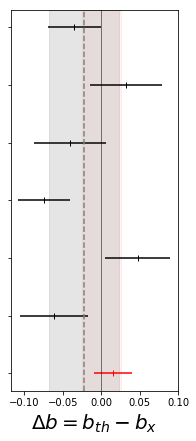

In [77]:
import scipy
theta_th, theory_sgc = np.loadtxt('../data_txt/acf_cmass_sgc_theory.txt', unpack=True)
theory_sgc_interp = scipy.interpolate.interp1d(theta_th, theory_sgc)
#theory_sgc_interp = theory_sgc_interp(meanr)

fig, ax = plt.subplots(figsize = (3,7))
brelsqr = np.linspace(0.8, 1.2, 5000) 
b_n = 2.0
brelarr = np.sqrt(brelsqr)
dbarray = b_n*(1-brelarr)
HF = lambda Nr,Nbin: (Nr-Nbin-2) *1./(Nr-1)

mock_num = 6
brelall = []
for j in range(mock_num):
    
    filename = basedir+ 'acf_auto_dmass_mock_{:04}_nbins10_jk100.txt'.format(j+1)
    covname = basedir+ 'acf_auto_dmass_mock_{:04}_nbins10_jk100.cov'.format(j+1)
    meanrw, xiw, xi_errw = np.loadtxt( filename, unpack=True)
    cov_dmass_w = np.loadtxt( covname, unpack=True)
    HFd = HF(30, 10)
    F_d = HFd * np.linalg.inv(cov_dmass_w)
    err_brelw, brelw, chisqr_resultw = brel_chisqr_fitting(xiw, theory_sgc_interp(meanrw), F_d, verbose=True)   
    #ax.errorbar(2.-2*brelw, mock_num+1-j, xerr =err_brelw*2., fmt='-|', color='k')
    ax.errorbar(2.-2*brelw, mock_num+1-j, xerr =err_brelw*2., fmt='-|', color='k')
    brelall.append(brelw)


meanr_sgc, xi_sgc, xi_err_sgc = np.loadtxt('../data_txt//acf_auto_cmass_sgc_sys_cp_nz_weight_nbins10_jk100.txt',unpack=True)
cov_cmass_s = np.genfromtxt('../data_txt//acf_auto_cmass_sgc_sys_cp_nz_weight_nbins10_jk100.cov')
HFs = HF(100, 10)
F_s = HFs * np.linalg.inv(cov_cmass_s)
err_brel_sgc, brel_sgc, chisqr_result_sgc = brel_chisqr_fitting(xi_sgc, theory_sgc_interp(meanr_sgc), F_s, verbose=True)
ax.errorbar(2.-2*brel_sgc, mock_num+1-j-1, xerr =err_brel_sgc*2., fmt='-|', color='r')

ax.axvspan(0.- err_brel_sgc*2, 0. + err_brel_sgc*2.,  alpha=0.05, color='red')
ax.axvline(x=0.0, color = 'black', ls='-', lw = 0.5)
brelall = np.array(brelall)
brelallmean = np.mean(brelall)
brelallstd = np.std(brelall)
ax.axvspan((2.-2.*brelallmean)- brelallstd*2, (2.-2.*brelallmean) + brelallstd*2.,  alpha=0.2, color='grey')
ax.axvline(x=2.-brelallmean*2, color = 'grey', ls='--')
 
#ax.set_xlabel(r'$\Delta b = b_{th} - b_x$', fontsize = 20)
ax.set_xlabel(r'$\Delta b = b_{th} - b_x$', fontsize = 20)
#ax.set_ylabel(r'$\chi^2$')
ax.legend(loc=1)
#ax.set_xlim(-0.1, 0.1)
#ax.set_yticks([1,2,3,4,5,6,7,8,9,10,11,12])
#ax.set_yticks(np.arange(1, mock_num+1 ))
ax.set_yticklabels( '', fontsize = 15) 
fig.savefig(rootdir + 'bias_weight.png')
print 'pic save to ', rootdir + 'bias_weight.png'

saving fig to  ../figure/hist_z_test.png


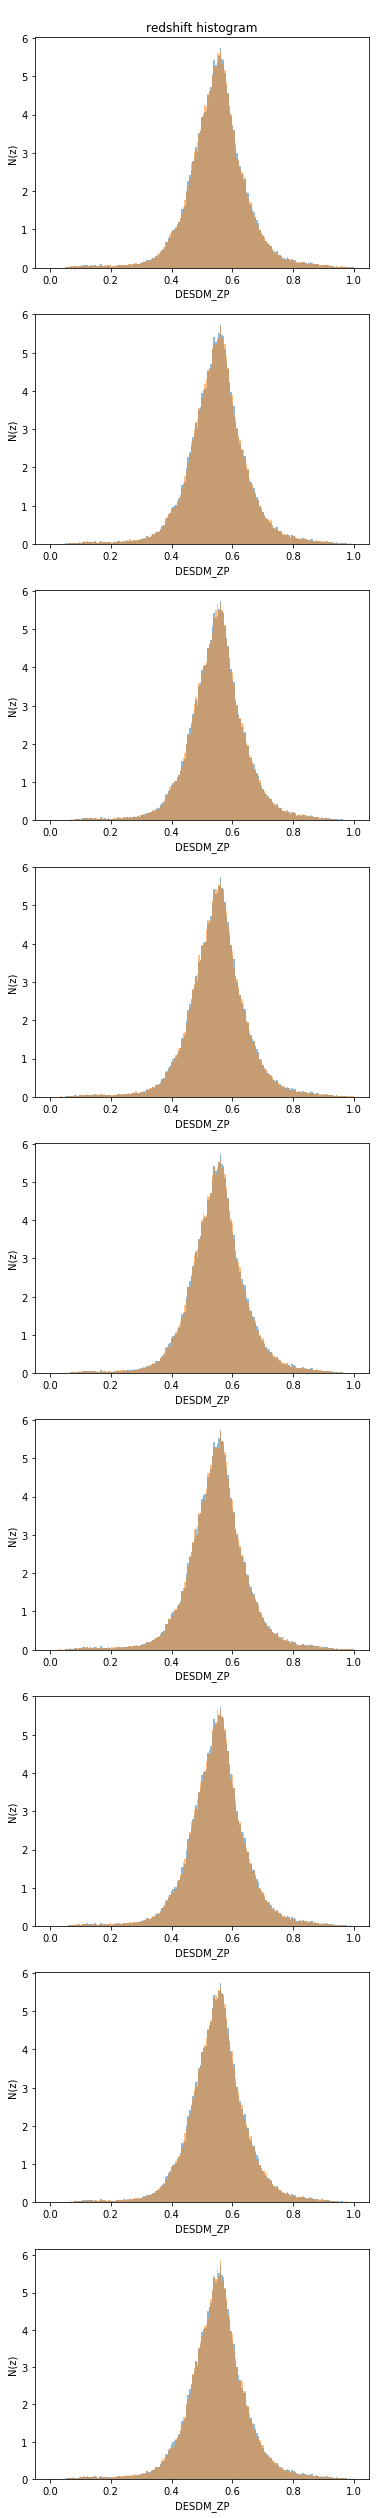

In [47]:
#dmass1 = fitsio.read('../output/mock/dmass_spt_{:04}.fits'.format(1))
#dmass2 = fitsio.read('../output/mock/dmass_spt_{:04}.fits'.format(2))

dmasslist = [ fitsio.read(rootdir+'dmass_spt_{:04}.fits'.format(i+1)) for i in range(10)]
doVisualization_z( cats = dmasslist, labels = None, suffix = 'test', zlabel = 'DESDM_ZP', outdir='../figure/' )


In [ ]:
#DAT = np.loadtxt('../data_txt/acf_auto_dmass_spt_nbins10_jk100.txt')
#meanr, xi, xi_err = [DAT[:,i] for i in range(3)]

meanr_sgc, xi_sgc, xi_err_sgc = np.loadtxt('../data_txt//acf_auto_cmass_sgc_sys_cp_nz_weight_nbins10_jk100.txt',unpack=True)
#DAT11 = np.loadtxt('../data_txt//acf_auto_cmass_ngc_sys_cp_nz_weight_nbin10_jk100.txt')
#meanr11, xi11, xi_err11 = [DAT11[:,i] for i in range(3)]
#cov_cmass_n = np.genfromtxt('../data_txt//acf_auto_cmass_ngc_sys_cp_nz_weight_nbin10_jk100.cov')
#cov_cmass_s = np.genfromtxt('../data_txt//acf_auto_cmass_sgc_sys_cp_nz_weight_nbins10_jk100.cov')
#cov_dmass = np.genfromtxt('../data_txt/acf_auto_dmass_spt_nbins10_jk100.cov')

##HF = lambda Nr,Nbin: (Nr-Nbin-2) *1./(Nr-1)
#HFn = HF(100, 10)
#HFs = HF(100, 10)
#HFd = HF(100, 10)#


#F_ns = HFn * HFs * np.linalg.inv(cov_cmass_n + cov_cmass_s)
#F_nd = HFn * HFd * np.linalg.inv(cov_cmass_n + cov_dmass)
#F_sd = HFs * HFd * np.linalg.inv(cov_cmass_s + cov_dmass)

In [ ]:

theta_th, theory = np.loadtxt('../data_txt/acf_cmass_ngc_theory.txt', unpack=True)
theta_th, theory_sgc = np.loadtxt('../data_txt/acf_cmass_sgc_theory.txt', unpack=True)

#_, theory_bias = np.loadtxt('../data_txt/acf_cmass_sgc_theory_bias.txt', unpack=True)

#theory_interp = scipy.interpolate.interp1d(theta_th, theory)
#theory_interp = theory_interp(meanr)
#theory_sgc_interp = scipy.interpolate.interp1d(theta_th, theory_sgc)
#theory_sgc_interp = theory_sgc_interp(meanr)

mock_num = 10

#fig, ax = plt.subplots(figsize = (7, 5))
fig, ax = plt.subplots(figsize = (10, 7))
for j in range(mock_num):
    
    filename = basedir+ 'acf_auto_dmass_mock_{:04}_nbins10_jk100.txt'.format(j+1)
    covname = basedir+ 'acf_auto_dmass_mock_{:04}_nbins10_jk100.cov'.format(j+1)
    meanrw, xiw, xi_errw = np.loadtxt( filename, unpack=True)
    cov_dmass_w = np.loadtxt( covname, unpack=True)
    HFd = HF(100, 10)
    F_d = HFd * np.linalg.inv(cov_dmass_w)
    #err_brelw, brelw, chisqr_resultw = brel_chisqr_fitting(xiw, theory_sgc_interp(meanrw), F_d, verbose=True)
    ax.errorbar(meanrw, xiw, yerr = xi_errw, fmt = '-', color='grey', alpha=0.2)
     
ax.errorbar(meanr_sgc*1.01, xi_sgc, yerr = xi_err_sgc, fmt = '-', color='red', alpha=0.9, label = 'cmass sgc')    
ax.plot(theta_th, theory_sgc, '-', color='k', label='theory sgc')
ax.errorbar(meanrw, xiw, yerr = xi_errw, fmt = '-', color='grey', alpha=0.1, label = 'mock')  
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc = 'best', fontsize = 12)
#ax.text(1.5, 0.07, r'$\chi^2 $ = {:0.3f}  (south)'.format(chisqr), fontsize = 12)
ax.set_ylim(1e-4,1)
ax.set_xlim(2.5/60, 250./60)
ax.set_xlabel(r'$\theta$ (deg)', fontsize = 15)
ax.set_ylabel(r'$\omega(\theta)$', fontsize = 15)

# Weight 

In [9]:
kind = 'SPT'
FullArea = SPTMaparea
#def CalculteGalaxyNgal(data, ):
#properties = ['DEPTH','EXPTIME']
#properties = ['DEPTH', 'EXPTIME', 'AIRMASS', 'SKYBRITE', 'FWHM', 'NSTARS']
properties = ['DEPTH', 'EXPTIME', 'AIRMASS', 'SKYBRITE', 'FWHM', 'NSTARS_allband','GE']
#properties = ['FWHM']
suffix='no_weight'

In [11]:
# calculating galaxy density and weights iterately
sysMap = calling_sysMap( properties=properties, kind='SPT', nside=4096 )


PATH =  /n/des/lee.5922/data/systematic_maps/Y1A1NEW_COADD_SPT/nside4096_oversamp4/
Y1A1NEW_COADD_SPT_band_g_nside4096_oversamp4_maglimit3__.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT

PATH =  /n/des/lee.5922/data/systematic_maps/Y1A1NEW_COADD_SPT/nside4096_oversamp4/
Y1A1NEW_COADD_SPT_band_r_nside4096_oversamp4_maglimit3__.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT

PATH =  /n/des/lee.5922/data/systematic_maps/Y1A1NEW_COADD_SPT/nside4096_oversamp4/
Y1A1NEW_COADD_SPT_band_i_nside4096_oversamp4_maglimit3__.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT

PATH =  /n/des/lee.5922/data/systematic_maps/Y1A1NEW_COADD_SPT/nside4096_oversamp4/
Y1A1NEW_COADD_SPT_band_z_nside4096_oversamp4_maglimit3__.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT

PATH =  /n/des/lee.5922/data/systematic_maps/Y1A1NEW_COADD_SPT/nside4096_oversamp4/
Y1A1NEW_COADD_SPT_band_g_nside4096_oversamp4_EXPTIME__total.fits.gz

In [12]:
dmass_masked = maskingCatalogSP(catalog=dmass, sysMap=sysMap)
rand_masked = maskingCatalogSP(catalog=rand, sysMap=sysMap)
rand2_masked = maskingCatalogSP(catalog=rand2, sysMap=sysMap)

112398 108272
mask  0.9632911617644442
510791 494623
mask  0.9683471321930105
2550725 2470300
mask  0.9684697487969107


In [262]:
weightname = 'wg_ge_g_fwhm_r_airmass_z_skybrite_i_skybrite_r_fwhm_i_airmass_r_skybrite_z_fwhm_g_airmass_g_exptime_z_exptime_g'

weightname = weightname.split('_')[1:]
order = []
for i in np.arange(0, len(weightname), 2):
    print weightname[i]+'_'+ weightname[i+1]
    order.append(weightname[i]+'_'+ weightname[i+1] )

ge_g
fwhm_r
airmass_z
skybrite_i
skybrite_r
fwhm_i
airmass_r
skybrite_z
fwhm_g
airmass_g
exptime_z
exptime_g


In [31]:
rootdir ='../data_txt/systematics/6th_include_ge/'
basedir = rootdir+'act/'
wdir = rootdir+'weights/'
os.system('mkdir '+basedir)
os.system('mkdir '+wdir)
#order = ['ge_g', 'fwhm_r', 'airmass_z', 'skybrite_i', 'airmass_g', 'fwhm_i', 'airmass_i', 'fwhm_g', 'skybrite_r', 'fwhm_z']
#order = ['fwhm_r','airmass_z', 'airmass_i', 'skybrite_i', 'skybrite_r', 'airmass_r', 'airmass_g', \
#         'nstars_allband_g', 'depth_i', 'exptime_g', 'fwhm_g', 'fwhm_z', 'exptime_z', 'depth_r', \
#         'fwhm_i', 'exptime_i', 'depth_g']
weightslist = [fitsio.read(wdir+'wg_'+o+'_SPT.fits') for o in order]
all_weight = np.ones(weightslist[0].size)
#for w in weightslist: all_weight *= w

In [32]:
os.system('cp ../data_txt/systematics/4th/act/acf_auto_dmass_nbins10_jk100.* '+basedir+'/.')
os.system('cp ../data_txt/systematics/4th/act/acf_auto_dmass_veto_nbins10_jk100.* '+basedir+'.')

0

In [264]:
angular_correlation(data = dmass, rand = rand2, nbins=10, weight = None, njack = 100, 
                        suffix = '_dmass_nbins10_jk100', dir = basedir)

calculate angular correlation function
X (1000, 2)  centers (100, 2)  tol=1e-05  maxiter=200
12 iterations  cluster sizes: [ 7  4  5 14  7  7  9  8 12  4  5  7  5  6 18 17 13 12  7  0  3  8  6  9
  5 15  7 19 13 13  8 17 10 12 10 11 18  9  7  9 15 12  8 18  5  3  8  4
 11  7 19 14 14 13 10  7  4  9 11  4 14 13 15 14  4 22 10 10  9 11 16  7
 15 12  1 12 11 15 12 12 14  9  8 14 11  8  2 11  7 14 10  5  4 12  8 13
 11 12 12  8]
X (112398, 2)  centers (100, 2)  tol=1e-05  maxiter=200
116 iterations  cluster sizes: [1027 1051  981 1273 1274  921 1229 1215  983  873 1057 1320 1067 1228
 1407 1294 1143 1149 1019 1028  951  942  983 1178 1350 1370 1165 1287
 1041 1123 1221 1191 1115 1224 1348 1068 1384 1164 1102  983 1350 1227
 1116  994 1253 1254 1178  857 1244  802 1310  870 1145 1137 1051  796
 1012 1384  937 1211 1189 1013 1181 1267  822 1192 1439 1350 1094  893
 1062  993 1131  899  910 1129  858 1559  790 1099 1403 1063 1145 1449
 1009 1060 1107 1032  894 1230 1012  959 1188 1132 1303 12

Exception KeyboardInterrupt in <bound method NNCorrelation.__del__ of NNCorrelation(config={'nbins': 10, 'split_method': 'mean', 'verbose': 1, 'min_sep': 0.041666666666666664, 'max_sep': 4.166666666666667, 'sep_units': 'deg', 'metric': 'Euclidean', 'precision': 4, 'pairwise': False, 'max_top': 10, 'm2_uform': 'Crittenden'})> ignored


 .

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/n/home00/lee.5922/.local/lib/python2.7/site-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/n/home00/lee.5922/.local/lib/python2.7/site-packages/IPython/core/ultratb.py", line 313, in wrapped
    return f(*args, **kwargs)
  File "/n/home00/lee.5922/.local/lib/python2.7/site-packages/IPython/core/ultratb.py", line 376, in _fixed_getinnerframes
    lines = ulinecache.getlines(file)[start:end]
  File "/n/home00/lee.5922/.local/lib/python2.7/site-packages/IPython/utils/ulinecache.py", line 37, in getlines
    return [l.decode(encoding, 'replace') for l in lines]
KeyboardInterrupt


IndexError: string index out of range

In [33]:
#tree corr
from systematics_module.corr import angular_correlation
os.system('mkdir '+basedir)
#angular_correlation(data = dmass, rand = rand2, nbins=10, weight = None, njack = 100, 
#                        suffix = '_dmass_nbins10_jk100', dir = basedir)

#angular_correlation(data = dmass_masked, rand = rand2_masked, nbins=10, weight = None, njack = 100, 
#                        suffix = '_dmass_veto_nbins10_jk100', dir = basedir)

for i in range(1,len(weightslist)+1):
    weight_com = np.ones(weightslist[0].size)
    for w in weightslist[:i]: weight_com *= w
    print i, order[i-1]
    
    angular_correlation(data = dmass_masked, rand = rand2_masked, nbins=10, weight = weight_com, njack = 100, 
                        suffix = '_dmass_weight'+str(i)+'_nbins10_jk100', dir = basedir)

1 ge_g
calculate angular correlation function
X (1000, 2)  centers (100, 2)  tol=1e-05  maxiter=200
13 iterations  cluster sizes: [12  8 11 10 11  4  9 15 10 37  5  7  7  8 10  7 12  7  8  7 14 15 11  8
  7  6 32 25 14 11  9 10  9  7  4 16 16  5 12  9 13 12  7 10  2  4  0  8
 12  7 10  4  7 13  7 12  9  9 11 13  8  4 14  9  9  8 10 10 12 12 11  8
 10 11  5  5  5  9  8 10  8  8 11  6 16 15  8 13  9 10  5 20 11 11  5  8
 11  9 12 11]
X (108272, 2)  centers (100, 2)  tol=1e-05  maxiter=200
131 iterations  cluster sizes: [1300 1509 1405 1000 1099 1080  967  897 1145 1931  653  781 1220 1043
  814  849  878  918  954 1009 1258 1192 1116  995  927  874 2253 1958
  903 1076  952  963 1144  921  819 1776 1359  868  855  868 1118 1179
  886 1205  952  725  887  914 2101  955 1133  772 1092 1130  905 2594
 1032  968  992 1101  935  749 1131 1213  907  883  926 1009 1131 1001
  856  902  676  883 1021  944 1180  822 1323 1377  951  916 1345 1078
 2012  894  994  806  897  946  896 1461 1406  903 

86 iterations  cluster sizes: [1065 1172  838 1110  834  969  858  988 1136  766 1095  972 1040  793
  763 1146 1157  964 1156  854 1163 1129 1125 1277 1421 1154  890 1221
  932 1176  616  961 1234  969 1364 1203  796  840 1220 1252 1324 1212
 1406 1298 1074 1357 1042  996  499 1175 1018 1118 1323 1108 1006  819
 1121  750 1050 1461 1145  863 1032  642 1179 1000 1220 1204 1379 1036
  910 1508  501 1194 1432 1080  790 1027 1439 1075 1407 1075 1000 1280
  841 1129 1226 1712 1120  836 1198 1294 1035  913  775 1478 1137 1013
 1237 1134]
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . saving data file to :  ../data_txt/systematics/6th_include_ge/act//acf_auto_dmass_weight7_nbins10_jk100.txt
8 skybrite_z
calculate angular correlation function
X (1000, 2)  centers (100, 2)  tol=1e-05  maxiter=200
16 iterations  cluster sizes: [12  3  6 13  8

err db, db / br1, brmin, br2 : 0.0430486225368798 -0.031578636660483994 0.9626761392440419 0.9844561091110935 1.0057247617809217
err db, db / br1, brmin, br2 : 0.043315893768491986 -0.019443745913897192 0.9684769432040722 0.9903717318428705 1.0117928369725642
err db, db / br1, brmin, br2 : 0.04348996207717393 -0.029485217893895133 0.9635069637183878 0.985471577898708 1.0069969257955618
err db, db / br1, brmin, br2 : 0.045262804093214926 -0.054521563121468386 0.9505475833127074 0.9734626474113842 0.9958103874059223
err db, db / br1, brmin, br2 : 0.048136814049466015 -0.0030073697504158226 0.9741200038785731 0.9984985727981668 1.0222568179280391
err db, db / br1, brmin, br2 : 0.044255424679410904 -0.01804486859179999 0.9686834723137929 0.9910582421269991 1.0129388969932038
err db, db / br1, brmin, br2 : 0.03955980245233004 -0.01755184080596761 0.9713231664789777 0.9913004263627961 1.0108829689313077
err db, db / br1, brmin, br2 : 0.04624779859843475 -0.032837801690568824 0.96047097868711

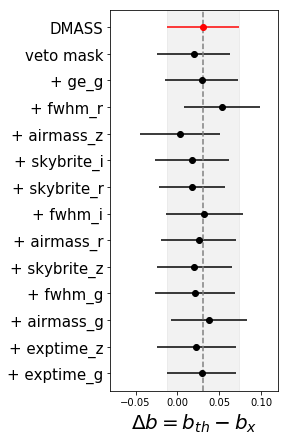

In [263]:

fig, ax = plt.subplots(figsize = (3,7))
brelsqr = np.linspace(0.8, 1.2, 5000) 
b_n = 2.0
brelarr = np.sqrt(brelsqr)
dbarray = b_n*(1-brelarr)

labels_SP = ['DMASS', 'veto mask'] + ['+ '+o for o in order ]

filenames = [ basedir+ 'acf_auto_dmass_nbins10_jk100.txt', \
              basedir + 'acf_auto_dmass_veto_nbins10_jk100.txt'] +\
[ basedir+'acf_auto_dmass_weight'+str(j)+'_nbins10_jk100.txt' for j in range(1, len(labels_SP))]

covnames = [ basedir+ 'acf_auto_dmass_nbins10_jk100.cov', \
              basedir + 'acf_auto_dmass_veto_nbins10_jk100.cov'] +\
[ basedir+'acf_auto_dmass_weight'+str(j)+'_nbins10_jk100.cov' for j in range(1, len(labels_SP))]


for j in range(1, len(labels_SP)+1):
    
    meanrw, xiw, xi_errw = np.loadtxt( filenames[j-1], unpack=True)
    cov_dmass_w = np.loadtxt( covnames[j-1], unpack=True)
    #meanrw, xiw, xi_errw = np.loadtxt(basedir+'acf_auto_dmass_weight'+str(j)+'_nbins10_jk100.txt', unpack=True)
    #cov_dmass_w = np.loadtxt(basedir+'acf_auto_dmass_weight'+str(j)+'_nbins10_jk100.cov', unpack=True)
    HFd = HF(100, 10)
    F_d = HFd * np.linalg.inv(cov_dmass_w)
    err_brelw, brelw, chisqr_resultw = brel_chisqr_fitting(xiw, theory_sgc_interp, F_d, verbose=True)
    if j == 1 : 
        color = 'red'
        ax.axvspan(2.-2*brelw - err_brelw*2., 2.-2*brelw + err_brelw*2.,  alpha=0.1, color='grey')
        ax.axvline(x=2.-2*brelw, color = 'grey', ls='--')
    else : color = 'k'  
        
    ax.errorbar(2.-2*brelw, len(labels_SP)+1-j, xerr =err_brelw*2., fmt='-o', color=color)
    
ax.set_xlabel(r'$\Delta b = b_{th} - b_x$', fontsize = 20)
#ax.set_ylabel(r'$\chi^2$')
ax.legend(loc=1)
ax.set_xlim(-0.1+0.02, 0.1+0.02)
#ax.set_yticks([1,2,3,4,5,6,7,8,9,10,11,12])
ax.set_yticks(np.arange(1, len(labels_SP)+1 ))

labels = labels_SP[::-1]
ax.set_yticklabels( labels, fontsize = 15) 
fig.savefig(rootdir + 'bias_weight.png')
print 'pic save to ', rootdir + 'bias_weight.png'


